In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
FEATURE_PATH = '../'

full_train_df = pd.read_csv(os.path.join(FEATURE_PATH, 'train_features.csv'))
print("Feature engineered training data loaded successfully")

Feature engineered training data loaded successfully


In [3]:
features = [col for col in full_train_df.columns if col not in [
    'object_id', 'target', 'split', 'English Translation'
]]
X = full_train_df[features]
y = full_train_df['target']
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)
print(f"Data prepared. Features shape: {X.shape}")

Data prepared. Features shape: (3043, 36)


In [ ]:
# Cross-Validation with Threshold Optimization
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

f1_scores = []
best_thresholds = []

print(f"\nStarting training with {N_SPLITS}-Fold CV and Threshold Optimization...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # LightGBM Model
    neg_count = y_train.value_counts()[0]
    pos_count = y_train.value_counts()[1]
    scale_pos_weight_value = neg_count / pos_count
    
    lgb_params = { 'objective': 'binary', 'metric': 'binary_logloss', 'n_estimators': 1000,
                   'learning_rate': 0.05, 'seed': 42, 'n_jobs': -1, 'verbose': -1,
                   'colsample_bytree': 0.8, 'subsample': 0.8, 'reg_alpha': 0.1,
                   'reg_lambda': 0.1, 'scale_pos_weight': scale_pos_weight_value }

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
              eval_metric='f1', callbacks=[lgb.early_stopping(100, verbose=False)])

    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    # Find Best Threshold
    thresholds = np.linspace(0.01, 0.99, 100)
    f1_values = [f1_score(y_val, (val_preds_proba > t).astype(int)) for t in thresholds]
    
    best_f1_idx = np.argmax(f1_values)
    best_threshold = thresholds[best_f1_idx]
    best_f1 = f1_values[best_f1_idx]
    
    f1_scores.append(best_f1)
    best_thresholds.append(best_threshold)
    
    print(f"Best Threshold: {best_threshold:.2f} -> F1 Score: {best_f1:.4f}")

# Final Results
mean_f1 = np.mean(f1_scores)
mean_threshold = np.mean(best_thresholds)
print("\n--- Cross-Validation Summary ---")
print(f"Mean Optimal Threshold: {mean_threshold:.2f}")
print(f"Mean F1 Score at Optimal Threshold: {mean_f1:.4f}")


Starting training with 5-Fold CV and Threshold Optimization...
--- Fold 1/5 ---
Best Threshold: 0.10 -> F1 Score: 0.3262
--- Fold 2/5 ---
Best Threshold: 0.41 -> F1 Score: 0.3934
--- Fold 3/5 ---
Best Threshold: 0.27 -> F1 Score: 0.4533
--- Fold 4/5 ---
Best Threshold: 0.22 -> F1 Score: 0.5846
--- Fold 5/5 ---
Best Threshold: 0.14 -> F1 Score: 0.3830

--- Cross-Validation Summary ---
Mean Optimal Threshold: 0.23
Mean F1 Score at Optimal Threshold: 0.4281



Training final model on all data to get feature importances...


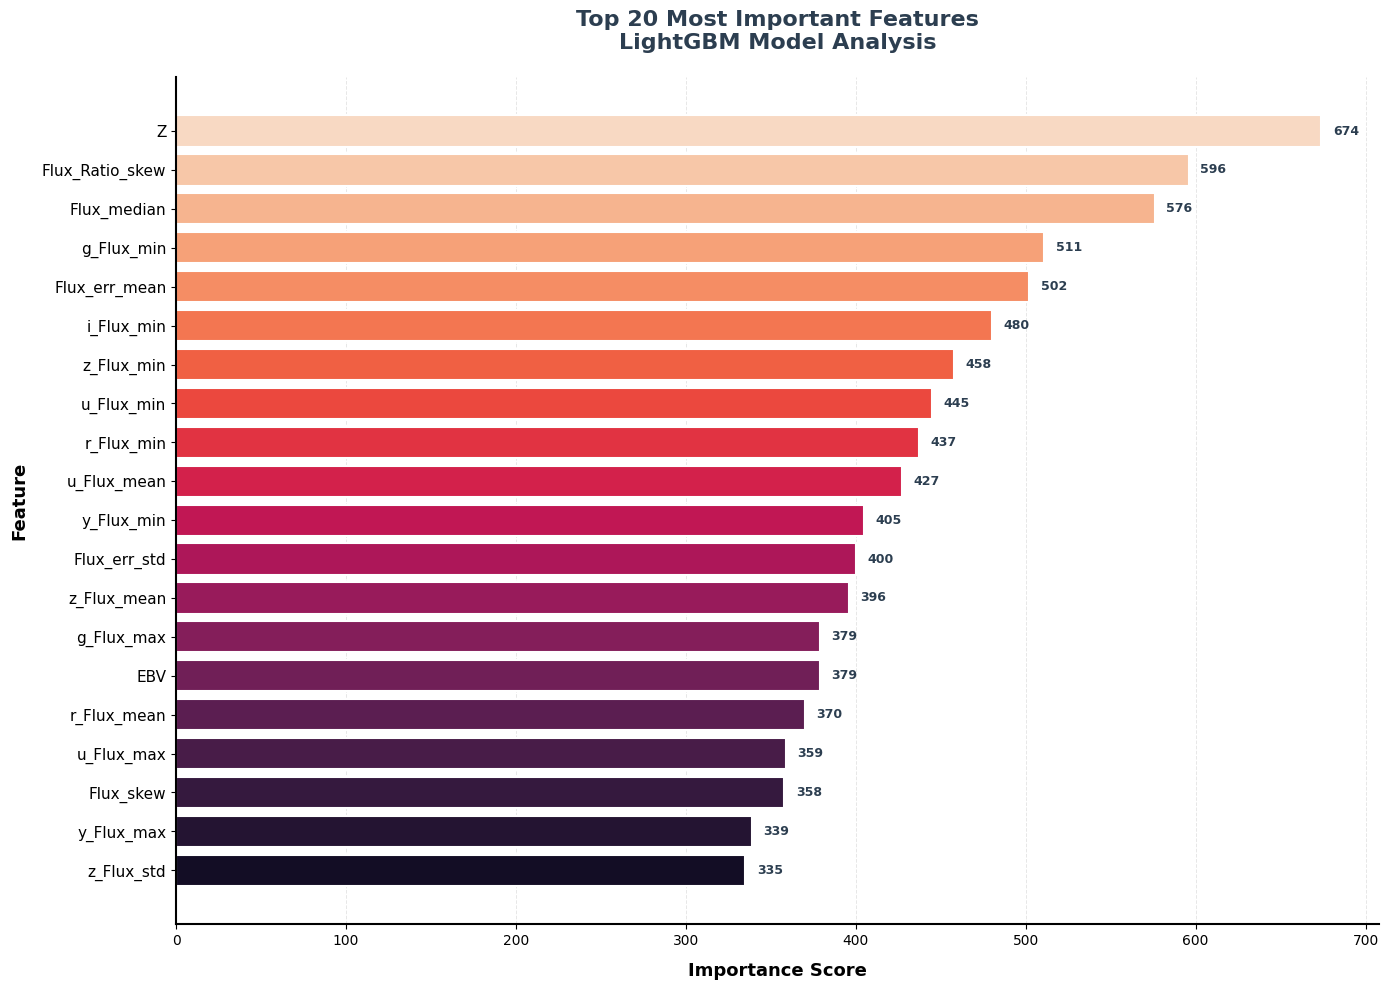


Top 20 Feature Importances:
 1. Z                             :     674.00
 2. Flux_Ratio_skew               :     596.00
 3. Flux_median                   :     576.00
 4. g_Flux_min                    :     511.00
 5. Flux_err_mean                 :     502.00
 6. i_Flux_min                    :     480.00
 7. z_Flux_min                    :     458.00
 8. u_Flux_min                    :     445.00
 9. r_Flux_min                    :     437.00
10. u_Flux_mean                   :     427.00
11. y_Flux_min                    :     405.00
12. Flux_err_std                  :     400.00
13. z_Flux_mean                   :     396.00
14. g_Flux_max                    :     379.00
15. EBV                           :     379.00
16. r_Flux_mean                   :     370.00
17. u_Flux_max                    :     359.00
18. Flux_skew                     :     358.00
19. y_Flux_max                    :     339.00
20. z_Flux_std                    :     335.00


In [ ]:
import json

# Feature Importance Analysis
print("\nTraining final model on all data to get feature importances...")
final_model = lgb.LGBMClassifier(**lgb_params)
final_model.fit(X, y)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(14, 10))

colors = sns.color_palette("rocket_r", n_colors=20)

bars = ax.barh(range(20), importance_df.head(20)['importance'], color=colors, edgecolor='white', linewidth=1.5)

ax.set_yticks(range(20))
ax.set_yticklabels(importance_df.head(20)['feature'], fontsize=11)
ax.invert_yaxis()

ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Feature', fontsize=13, fontweight='bold', labelpad=10)

for i, (bar, value) in enumerate(zip(bars, importance_df.head(20)['importance'])):
    ax.text(value + max(importance_df.head(20)['importance']) * 0.01, 
            bar.get_y() + bar.get_height()/2, 
            f'{value:.0f}',
            va='center', fontsize=9, fontweight='bold', color='#2c3e50')

ax.set_title('Top 20 Most Important Features\nLightGBM Model Analysis', 
             fontsize=16, fontweight='bold', pad=20, color='#2c3e50')

ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print top 20 features numerically
top_features = importance_df.head(20)
print("\nTop 20 Feature Importances:")
print("=" * 50)
for idx, (i, row) in enumerate(top_features.iterrows(), 1):
    print(f"{idx:2d}. {row['feature']:30s}: {row['importance']:10.2f}")
print("=" * 50)

By simply optimizing the decision threshold, the mean F1 score jumped from 0.2917 to 0.4281. This is a huge improvement and confirms that a default 0.5 threshold is not suitable for this problem. The mean optimal threshold of 0.23 tells us the model needs to be much more "lenient" in predicting a TDE to achieve the best balance between precision and recall.


**Feature Importance analysis:** The feature importance plot gives us invaluable clues about what the model is learning:

* Redshift is Key: Z (Redshift) is the single most important feature. This suggests that TDEs might occur preferentially within a certain distance range that the model is picking up on.
* Signal-to-Noise Matters: Flux_Ratio_skew is the second most important feature. This implies that the shape of the distribution of the signal-to-noise ratio is a powerful discriminator. A TDE might have a more skewed SNR profile than other transients.
* Minimum Brightness is Crucial: We see a recurring theme of _min features (g_Flux_min, i_Flux_min, etc.) being highly ranked. The faintest flux an object reaches seems to be a very important characteristic, perhaps because TDEs have a distinct "off" state compared to the simmering baseline of an AGN.
* Metadata is Still Valuable: The original metadata features (Z and EBV) are both highly ranked, confirming they are essential to keep.

Next step would be try some automated time-series feature engineering library like `tsfresh`
